<h1 align="center" style="color: navy; font-size: 30px;">🚀 TuberAI: CNN ile Tüberküloz Teşhisi</h1>


## 🩺 Veri Setine Genel Bakış

Bu proje, göğüs röntgeni (*Chest X-Ray, CXR*) görüntülerini kullanarak tüberküloz tespiti yapan bir **Convolutional Neural Network (CNN)** projesidir.  
Projedeki genel amaç, **tüberküloz** ve **normal** göğüs röntgenlerini sınıflandırarak CNN ile otomatik tespit yapabilmektir.

Sağlık verileri, özellikle **erken teşhis** açısından son derece önem taşır. Bu tür projeler, hızlı ve doğru tanı koyma konusunda sağlık sektörüne yardımcı olabilir, insan hatasını azaltabilir ve hastaların uygun tedaviye daha hızlı ulaşmasına katkı sağlar.  
Bu veri seti de bu titizlik göz önünde bulundurularak analiz edilmiştir.

---

### Veri Seti

- Kaggle üzerindeki *Tuberculosis (TB) Chest X-ray Dataset*  
- Her örnek bir göğüs röntgen görüntüsüdür  
- Amaç: Görüntü sınıflandırma — **TB var / yok**  
- Bu veri seti, bir **ikili sınıflandırma (binary classification)** problemidir  
- Herkese açık olan içerik:  
  - 700 TB pozitif görüntü  
  - 3500 normal göğüs röntgeni  

---

### 🛠 Kullanılan Teknolojiler ve Kütüphaneler

- *Python 3.x*
- *NumPy & Pandas*
- *Matplotlib & Seaborn*
- *OpenCV & PIL*
- *TensorFlow / Keras*
- *Scikit-learn*
- *Random*
- *L2 Regularizer*

## 1. Veri Setine Giriş

İlk olarak veri seti yüklenmiş ve klasör yapısı incelenmiştir. Kod ile veri setinin yolu tanımlanmış ve klasördeki dosyalar listelenmiştir.

Veri setinin hem **tüberküloz (TB)** hem de **normal** sınıfları içerdiği, ek olarak *metadata* ve *README* dosyalarının bulunduğu görülmektedir. Bu adım, veri setinin yapısını anlamak ve sonraki analizler için hazırlık yapmak açısından önemlidir.

İkinci aşamada, her iki sınıftaki görüntülerin yapısını ve **dosya isimlendirme formatını** anlamak amacıyla iki sınıftan örnek dosya isimleri görüntülenmiştir.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras.regularizers import l2


data = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/'
os.listdir(data)

E0000 00:00:1758919569.490261      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758919569.591756      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['Normal.metadata.xlsx',
 'Tuberculosis',
 'README.md.txt',
 'Tuberculosis.metadata.xlsx',
 'Normal']

In [2]:
tuberculosis_data= "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis"
print("tuberculosis images :\n" ,os.listdir(tuberculosis_data)[:5])

normal_data= "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"
print("\nnormal images :\n" ,os.listdir(normal_data)[:5])

tuberculosis images :
 ['Tuberculosis-173.png', 'Tuberculosis-334.png', 'Tuberculosis-309.png', 'Tuberculosis-487.png', 'Tuberculosis-178.png']

normal images :
 ['Normal-859.png', 'Normal-158.png', 'Normal-1811.png', 'Normal-97.png', 'Normal-1088.png']


## 2. Sınıf Dağılımı

Veri setinin dengeli olup olmadığını incelemek için her iki sınıfta kaç adet görüntü bulunduğu kontrol edilmiştir.  
Sınıf dağılımını daha görsel hâle getirmek amacıyla bir bar chart oluşturulmuştur.

Veri setindeki sınıf dağılımı aşağıdaki gibidir:

- **Tuberculosis:** 700 görüntü  
- **Normal:** 3500 görüntü  

Bu durum, veri setinin **dengesiz** olduğunu göstermektedir.  
Modelin öğrenme sürecinde Normal sınıfına aşırı ağırlık vermesi ve TB sınıfını doğru tahmin etmede zorlanması olasıdır.  

Normal sınıfın çubuğu, Tuberculosis sınıfına göre çok daha uzun olacaktır; bu da dengesizliği net bir şekilde ortaya koymaktadır.  
Bu problemi çözmek için, model eğitiminden önce azınlık sınıfındaki (**Tuberculosis**) görüntülere **data augmentation** uygulanacaktır. Döndürme, çevirme veya parlaklık değişikliği gibi tekniklerle TB sınıfı çeşitlendirilecektir.


In [3]:
num_tuberculosis = len(os.listdir(tuberculosis_data))
num_normal = len(os.listdir(normal_data))
total = num_tuberculosis + num_normal

# Sonuçları pandas DataFrame ile tablo şeklinde gösterdim.
class_counts = pd.DataFrame({
    "Class": ["Tuberculosis", "Normal"],
    "Count": [num_tuberculosis, num_normal],
    "Percent (%)":[num_tuberculosis/total*100,num_normal/total*100]
})

display(class_counts)

,Class,Count,Percent (%)
0,Tuberculosis,700,16.666667
1,Normal,3500,83.333333


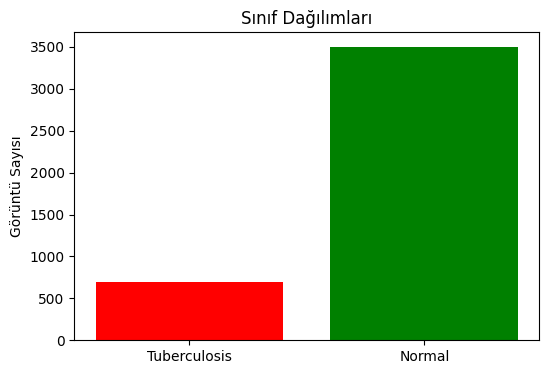

In [4]:
plt.figure(figsize=(6,4))
plt.bar(class_counts["Class"], class_counts["Count"], color=["red", "green"])
plt.title("Sınıf Dağılımları")
plt.ylabel("Görüntü Sayısı")
plt.show()

## 3. Görsellerin Teknik İncelemesi

Bu aşamada görsellerin boyutlarının uyumlu olması, çözünürlükleri, renk farklılıkları ve dosyaların eksik veya bozuk olup olmadığı incelenmiştir.  
CNN modelleri için bu adım önemlidir; çünkü modelin girdi katmanında kullanılacak boyutların netleşmesi, renk kanallarının doğru yönetilmesi ve bozuk verilerin ayıklanması, eğitimin doğruluğunu doğrudan etkiler.  
Bu çıktılar incelenerek model için uygun input boyutu ve ön işleme adımları planlanacaktır.


### 3.1 Görsellerin Teknik Özellikleri

- Veri setindeki tüm görseller **512×512 piksel** boyutunda ve **renkli (3 kanal)** formatındadır.  
- Göğüs röntgenlerinde renk bilgisi anlamlı olmadığından, eğitimde görseller **gri tonlamaya (tek kanal)** dönüştürülecektir.  
- 512×512 çözünürlük yüksek doğruluk sağlasa da eğitim süresi açısından maliyetlidir. Bu nedenle, tüm görseller **224×224** boyutuna yeniden boyutlandırılacaktır. Bu yaklaşım, GPU bellek kullanımını optimize eder ve eğitim süresini kısaltır.  
- Piksel değerleri **0–255** aralığında olduğundan, model eğitiminde veriler **0–1 aralığına normalize** edilecektir.  
- Ek bir ön işleme gerek yoktur.  
- Veri setinde bozuk veya eksik dosya bulunmamaktadır; bu sayede veri temizleme süreci basit olup modelin güvenilir şekilde eğitilmesini sağlamaktadır.


In [5]:
classes = ["Tuberculosis", "Normal"]

def analyze_images(data_dir, classes, num_samples=3):
    sizes = set()
    modes = set()
    
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for img_file in os.listdir(cls_dir):
            path = os.path.join(cls_dir, img_file)
            img = cv2.imread(path)
            if img is None:
                print("Bozuk dosya:", path)
                continue
            sizes.add((img.shape[0], img.shape[1])) 
            modes.add(img.shape[2] if len(img.shape)==3 else 1)  
    
    print("Unique boyutlar:", sizes)
    print("Unique kanallar(1=grayscale, 3=RGB):", modes)
    
    sample_img = cv2.imread(os.path.join(data_dir, classes[0], os.listdir(os.path.join(data_dir, classes[0]))[0]))
    print("\nGenel Piksel Değerleri Aralığı -> Min:", np.min(sample_img), "Max:", np.max(sample_img))
    print("----------------------------------------------------------------------")
    
    print("\nSınıflardan Örnek Görseller: ")
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        sample_files = random.sample(os.listdir(cls_dir), num_samples)
        print(f"\nClass: {cls}")
        for f in sample_files:
            img_path = os.path.join(cls_dir, f)
            img = cv2.imread(img_path)
            if img is None:
                print("  Bozuk dosya:", f)
                continue
            print(f"  {f} -> Min: {np.min(img)}, Max: {np.max(img)}, Shape: {img.shape}")

analyze_images(data, classes)

Unique boyutlar: {(512, 512)}
Unique kanallar(1=grayscale, 3=RGB): {3}

Genel Piksel Değerleri Aralığı -> Min: 0 Max: 253
----------------------------------------------------------------------

Sınıflardan Örnek Görseller: 

Class: Tuberculosis
  Tuberculosis-483.png -> Min: 0, Max: 225, Shape: (512, 512, 3)
  Tuberculosis-386.png -> Min: 0, Max: 255, Shape: (512, 512, 3)
  Tuberculosis-401.png -> Min: 0, Max: 255, Shape: (512, 512, 3)

Class: Normal
  Normal-1392.png -> Min: 0, Max: 247, Shape: (512, 512, 3)
  Normal-1272.png -> Min: 0, Max: 229, Shape: (512, 512, 3)
  Normal-1298.png -> Min: 0, Max: 255, Shape: (512, 512, 3)


### 3.2 Sınıf Bazlı Piksel İstatistikleri

Veri setindeki her sınıfın görselleri için **ortalama parlaklık (mean)** ve **kontrast/dağılım (std)** değerleri hesaplanmıştır. Elde edilen sonuçlar:

- **Normal sınıf:** Mean = 130.12, Std = 62.05  
- **Tuberculosis sınıf:** Mean = 125.50, Std = 53.06  

Bu bulgular, TB görsellerinin ortalama olarak Normal görsellere göre biraz daha koyu ve daha homojen (daha düşük standart sapma) olduğunu göstermektedir.  
Sınıflar arası bu küçük parlaklık ve kontrast farkı, normalizasyon ve veri ön işleme stratejilerinin belirlenmesinde yol gösterici olabilir.  

Bu nedenle, tüm görsellerin **0–1 aralığında normalize edilmesi**, modelin daha stabil ve hızlı öğrenmesi için uygun bir yöntem olarak tercih edilmiştir.


In [6]:
means_all, stds_all = [], []

for i, cls in enumerate(classes):
    cls_dir = os.path.join(data, cls)
    means, stds = [], []
    
    for img_file in os.listdir(cls_dir):
        img = cv2.imread(os.path.join(cls_dir, img_file), cv2.IMREAD_GRAYSCALE)
        means.append(np.mean(img))
        stds.append(np.std(img))
    
    means_all.append(means)
    stds_all.append(stds)
    
    print(f"{cls} - Mean: {np.mean(means):.2f}, Std: {np.mean(stds):.2f}")

Tuberculosis - Mean: 125.50, Std: 53.06
Normal - Mean: 130.12, Std: 62.05


## 4. Verilerin Görselleştirmesi

Bu adımda, her iki sınıftan rastgele seçilen birkaç örnek görüntü **grid şeklinde** gösterilmiştir. Görselleştirme, veri setindeki görsel çeşitliliği ve sınıflar arasındaki farklılıkları daha iyi anlamamıza yardımcı olur.

Gözlemler:

- Görseller arasında **kontrast** ve **parlaklık** farklılıkları mevcuttur.  
- **Tuberculosis** sınıfındaki görüntülerde akciğerlerde leke, yoğunluk veya yapısal değişiklikler gibi tüberküloz belirtileri farklı şekillerde ortaya çıkmaktadır.  
- **Normal** sınıfındaki görüntüler daha homojen olup belirgin patolojik değişiklik içermez.  

Her iki sınıfın genel görsel karakteristikleri ve yoğunluk dağılımları farklıdır; bu durum, modelin sınıfları ayırt etmesi için önemli bir bilgi sağlamaktadır.


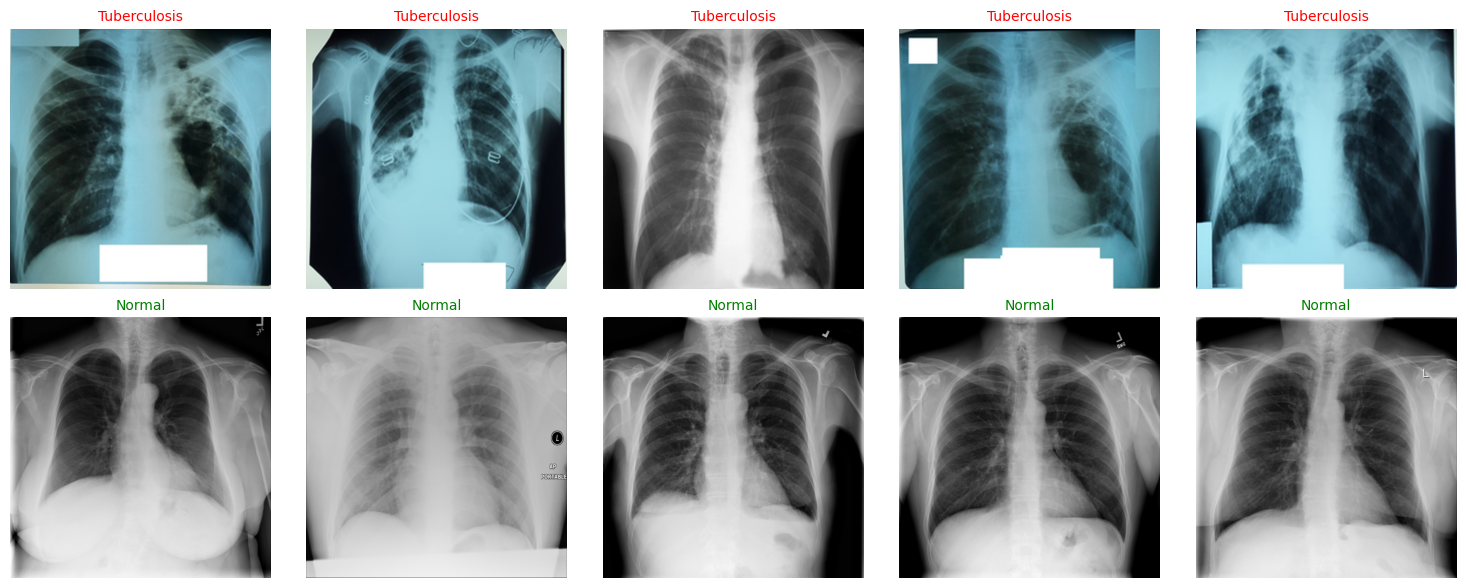

In [7]:
sns.set(style="whitegrid")

n_per_class = 5  # Her sınıftan 5 örnek
fig, axs = plt.subplots(len(classes), n_per_class, figsize=(n_per_class*3, len(classes)*3))

for i, cls in enumerate(classes):
    cls_dir = os.path.join(data, cls)
    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    samples = random.sample(imgs, min(len(imgs), n_per_class))
    
    for j, f in enumerate(samples):
        img_path = os.path.join(cls_dir, f)
        img = Image.open(img_path)
        
        ax = axs[i][j] if len(classes) > 1 else axs[j]
        ax.imshow(img,cmap="gray")
        
        color = 'red' if cls == "Tuberculosis" else 'green'
        ax.set_title(cls, color=color, fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Normalizasyon ve Veri Önişleme

Bu aşamada veri seti **train, validation ve test** kümelerine ayrılmış ve azınlık sınıf olan **Tuberculosis (TB)** sınıfı için **data augmentation** uygulanarak sınıf dağılımı dengelenmiştir. İşlem adımları aşağıdaki gibidir: 

---

### *5.1 Klasör yapısı ve sınıfların belirlenmesi:*
   Veri setindeki iki ana sınıf (*Normal* ve *Tuberculosis*) tespit edilmiş ve ilgili dosya yolları (`filepaths`) ile etiketler (`labels`) bir DataFrame hâline getirilmiştir.  

### *5.2 Train/Validation/Test ayırımı:*
   Veri seti, stratified (sınıf oranlarını koruyacak şekilde) bir yöntemle ayrılmıştır:  
   - Train: %72.25  
   - Validation: %12.75  
   - Test: %15  
   Bu oranlar, modelin hem öğrenmesi hem de performans değerlendirmesi için dengeli bir dağılım sağlar.

In [8]:
data_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
aug_dir = "/kaggle/working/Tuberculosis_augmented_train"
os.makedirs(aug_dir, exist_ok=True)

filepaths = []
labels = []

for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.png','.jpg','.jpeg')):
            filepaths.append(os.path.join(cls_dir, fname))
            labels.append(cls)

df = pd.DataFrame({'filename': filepaths, 'class': labels})

df_trainval, df_test = train_test_split(df, test_size=0.15, stratify=df['class'], random_state=42)
val_ratio = 0.15 / 0.85  
df_train, df_val = train_test_split(df_trainval, test_size=val_ratio, stratify=df_trainval['class'], random_state=42)

print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

Train: 2940, Validation: 630, Test: 630


### *5.3 Tuberculosis sınıfının dengelemesi:* 
   Train setindeki TB örnekleri, Normal sınıf sayısına eşitlenmek amacıyla **ImageDataGenerator** kullanılarak artırılmıştır.  
   - Uygulanan augmentasyon teknikleri: `rotation_range=20`, `width_shift_range=0.1`, `height_shift_range=0.1`, `zoom_range=0.1`, `horizontal_flip=True`  
   - Üretilen yeni görseller, `aug_dir` klasörüne kaydedilmiş ve train setine eklenmiştir.  
   Bu sayede azınlık sınıfındaki örnek sayısı, çoğunluk sınıfına eşitlenerek modelin sınıflar arası dengesizliğe bağlı hatalar üretmesi önlenmiştir.

In [9]:
tb_train = df_train[df_train['class']=='Tuberculosis'].copy()
num_tb = len(tb_train)
target_tb = df_train['class'].value_counts()['Normal']  # Normal sınıf sayısına eşitle
needed = target_tb - num_tb

print(f"Tuberculosis train: {num_tb}, Hedef: {target_tb}, Üretilecek: {needed}")

Tuberculosis train: 490, Hedef: 2450, Üretilecek: 1960


In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

count = 0
for idx, row in tb_train.iterrows():
    if count >= needed:
        break
    img_path = row['filename']
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))
    img = img.reshape((1,224,224,1))
    
    for batch in datagen.flow(img, batch_size=1, save_to_dir=aug_dir,
                              save_prefix='aug', save_format='png'):
        count += 1
        if count >= needed:
            break

print(f"{count} yeni augmented Tuberculosis görseli üretildi")

1960 yeni augmented Tuberculosis görseli üretildi


In [11]:
aug_files = [os.path.join(aug_dir, f) for f in os.listdir(aug_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
df_aug = pd.DataFrame({'filename': aug_files, 'class': ['Tuberculosis']*len(aug_files)})

df_train_balanced = pd.concat([df_train, df_aug], ignore_index=True)
print(f"Train setindeki güncel sınıf dağılımı:\n{df_train_balanced['class'].value_counts()}")

Train setindeki güncel sınıf dağılımı:
class
Normal          2450
Tuberculosis    2270
Name: count, dtype: int64


### *5.4 ImageDataGenerator ile veri yükleyici oluşturma:*
   - **Train generator:** normalize edilmiş ve augmentasyon uygulanmış görseller ile oluşturulmuştur.  
   - **Validation ve test generator:** yalnızca normalize edilmiş görseller kullanılmıştır.  
   - Tüm görseller **224×224 piksel** boyutunda ve **grayscale** formatında işlenmiştir.  

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train_balanced,
    x_col='filename',
    y_col='class',
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='class',
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    y_col='class',
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4720 validated image filenames belonging to 2 classes.
Found 630 validated image filenames belonging to 2 classes.
Found 630 validated image filenames belonging to 2 classes.


### *5.5 Sınıf dağılımlarının kontrolü:* 
   - Train seti (augmentation sonrası) dengelenmiş hâle gelmiştir.  
   - Validation ve test setlerinde orijinal dağılım korunmuştur.  

In [13]:
print("📊 Güncel Sınıf Dağılımları:")
print("Train:")
print(df_train_balanced['class'].value_counts())
print("Validation:")
print(df_val['class'].value_counts())
print("Test:")
print(df_test['class'].value_counts())

📊 Güncel Sınıf Dağılımları:
Train:
class
Normal          2450
Tuberculosis    2270
Name: count, dtype: int64
Validation:
class
Normal          525
Tuberculosis    105
Name: count, dtype: int64
Test:
class
Normal          525
Tuberculosis    105
Name: count, dtype: int64


## 6. Model Mimarisi

Tasarlanan CNN mimarisi, görüntü sınıflandırma problemleri için yaygın olarak kullanılan katmanlar ve düzenlileştirme tekniklerini içermektedir:  

- **Convolutional Layers**  
  Görsellerden öznitelik (feature) çıkarmak amacıyla 3 adet konvolüsyon katmanı kullanılmıştır. Bu katmanlar, farklı seviyelerde kenar, şekil ve doku bilgilerini yakalayarak modelin sınıflar arasında ayrım yapabilmesini sağlamaktadır.  

- **Pooling Layers**  
  Her konvolüsyon katmanının ardından **MaxPooling (2×2)** uygulanmıştır. Bu sayede boyutlar küçültülerek hesaplama maliyeti azaltılmış, aynı zamanda özniteliklerin daha genelleştirilmiş bir temsili elde edilmiştir.  

- **Dense (Fully Connected) Layers**  
  Konvolüsyon katmanlarından sonra Flatten işlemi ile veriler vektöre dönüştürülmüş ve tam bağlantılı (dense) katmanlara aktarılmıştır.  
  - İlk dense katmanda **128 nöron**, **ReLU aktivasyonu** ve **L2 regularizasyonu (0.001)** kullanılmıştır.  
  - Çıkış katmanında ise **sigmoid aktivasyonu** ile ikili sınıflandırma yapılmıştır.  

- **Dropout**  
  Aşırı öğrenmeyi (overfitting) önlemek amacıyla %50 oranında dropout uygulanmıştır. Bu yöntem, eğitim sırasında bazı bağlantıları devre dışı bırakarak modelin daha sağlam bir genelleme yapmasına katkı sağlar.  

- **L2 Regularizasyonu**  
  Hem konvolüsyon katmanlarında hem de dense katmanda **L2 (Ridge) regularizasyonu** uygulanmıştır. Bu teknik, büyük ağırlık değerlerini cezalandırarak modelin daha basit ve genelleştirilebilir bir çözüm öğrenmesine yardımcı olur.  

- **Aktivasyon Fonksiyonları**  
  - **ReLU (Rectified Linear Unit):** Konvolüsyon ve dense katmanlarında kullanılarak doğrusal olmayan ilişkilerin öğrenilmesine imkân tanımaktadır.  
  - **Sigmoid:** Çıkış katmanında kullanılarak modelin çıktısının 0–1 aralığında bir olasılık değeri üretmesi sağlanmıştır.  

> Bu yapı sayesinde model, görsellerden anlamlı öznitelikleri çıkarıp genelleştirebilmekte, düzenlileştirme teknikleriyle (Dropout + L2) aşırı öğrenme riski azaltılmakta ve ikili sınıflandırma görevini başarıyla yerine getirebilecek kapasiteye ulaşmaktadır.  


In [14]:
input_layer = Input(shape=(224,224,1))

x = Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001), name='last_conv')(x)
x = MaxPooling2D(2,2)(x)

x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

I0000 00:00:1758919731.481209      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758919731.482016      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### 6.2 Modelin Derlenmesi  

Modelin eğitime hazır hale getirilmesi için derleme (compile) aşamasında aşağıdaki ayarlar yapılmıştır:  

- **Optimizer:** `Adam`  
  - Adaptif öğrenme oranına sahip olduğundan, eğitim sürecinde parametre güncellemelerini dengeli bir şekilde gerçekleştirmektedir.  

- **Loss Function:** `Binary Crossentropy`  
  - İkili sınıflandırma problemi (Normal / Tüberküloz) için en uygun kayıp fonksiyonu tercih edilmiştir. Modelin tahmin ettiği olasılıklar ile gerçek etiketler arasındaki farkı minimize eder.  

- **Metrics:** `Accuracy`  
  - Eğitim ve doğrulama sürecinde modelin başarımını ölçmek için doğruluk (accuracy) metriği kullanılmıştır.  

Ayrıca, `model.summary()` fonksiyonu ile modelin katman yapısı, her katmandaki parametre sayısı ve toplam parametre sayısı görüntülenmiştir. Bu özet tablo, modelin mimarisini ve karmaşıklığını incelemek için kullanılmıştır.  


In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

### 6.3 Modelin Eğitilmesi  

Model, `fit()` fonksiyonu ile 15 epoch boyunca eğitilmiştir.  
Eğitim için `train_generator`, doğrulama için `val_generator` kullanılmıştır.  
Eğitim süreci boyunca doğruluk (accuracy) ve kayıp (loss) değerleri `history` değişkeninde saklanmıştır.  


In [16]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1758919737.049708      65 service.cc:148] XLA service 0x7aa8e0004970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758919737.051599      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758919737.051623      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758919737.508136      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/148 ━━━━━━━━━━━━━━━━━━━━ 23:26 10s/step - accuracy: 0.5625 - loss: 1.0746

I0000 00:00:1758919743.847788      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 61s 353ms/step - accuracy: 0.7781 - loss: 0.7066 - val_accuracy: 0.8905 - val_loss: 0.4194
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step - accuracy: 0.9166 - loss: 0.3419 - val_accuracy: 0.8889 - val_loss: 0.3819
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.9202 - loss: 0.3027 - val_accuracy: 0.8937 - val_loss: 0.3495
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 317ms/step - accuracy: 0.9259 - loss: 0.2717 - val_accuracy: 0.9238 - val_loss: 0.2990
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.9371 - loss: 0.2347 - val_accuracy: 0.9143 - val_loss: 0.3037
Epoch 6/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 318ms/step - accuracy: 0.9432 - loss: 0.2333 - val_accuracy: 0.9159 - val_loss: 0.2889
Epoch 7/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.9405 - loss: 0.2246 - val_accuracy: 0.9190 - val_loss: 0.2680
Epoch 8/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 318ms/step - accuracy: 0.9514 - loss: 0.1953 - val

### 6.4 Modelin Değerlendirilmesi

Model 15 epoch boyunca eğitilmiş ve eğitim ile doğrulama performansları takip edilmiştir.  

- **Eğitim ve Doğrulama Performansı:**  
  - Modelin eğitim doğruluğu (accuracy) ilk epochlarda %77 civarındayken, son epochlarda %95 seviyelerine ulaşmıştır.  
  - Doğrulama doğruluğu ise ilk başta %89, son epochlarda %93.8 olarak gerçekleşmiştir.  
  - Kayıp (loss) değerleri eğitim boyunca azalmış ve son epochlarda minimuma yaklaşmıştır.  

- **Öğrenme Eğilimi ve Genelleme:**  
  - Eğitim doğruluğunun sürekli artması ve doğrulama doğruluğunun da benzer bir trend göstermesi, modelin veriyi iyi öğrenmeye başladığını ve aşırı öğrenme (overfitting) riskinin minimal olduğunu göstermektedir.  
  - Epoch 3–4 civarında doğrulama doğruluğunda küçük dalgalanmalar görülse de, bu normal bir durumdur ve modelin öğrenme sürecinde küçük ayarlamalar yaptığı anlamına gelir.  
  - Son epochlarda doğrulama doğruluğunun eğitim doğruluğuna yakın olması, modelin hem eğitim hem de daha önce görmediği veriler üzerinde sağlam bir genelleme yapabildiğini göstermektedir.  

- **Test Seti Performansı:**  
  - Model, test seti üzerinde %93.17 doğruluk elde etmiştir.  
  - Bu yüksek doğruluk, modelin hem TB hem de normal sınıfları ayırt etmede başarılı olduğunu ve sınıf dengesizliğine rağmen iyi genelleme yaptığını doğrulamaktadır.  

> Genel olarak, model hem öğrenme kapasitesini doğru kullanmış hem de overfitting olmadan sınıflar arasındaki ayrımı başarıyla gerçekleştirmiştir.  


In [17]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.9452 - loss: 0.1990
Test Accuracy: 0.9476


## 7. Accuracy & Loss Grafikleri

Aşağıdaki grafikler, modelin 15 epoch boyunca eğitim ve doğrulama performansını göstermektedir. 

- **Accuracy Grafiği:**  
  - Eğitim doğruluğu sürekli artarak %95.17 civarına ulaşmıştır.  
  - Doğrulama doğruluğu da benzer bir trend izlemiş ve son epochlarda %93.81 seviyesine çıkmıştır. 
  - Doğrulama doğruluğundaki küçük dalgalanmalar, modelin veri setindeki çeşitliliğe tepki verdiğini ve öğrenme sürecinde küçük ayarlamalar yaptığını göstermektedir.  

- **Loss Grafiği:**  
  - Eğitim kaybı (loss) düzenli şekilde azalmış ve son epochlarda minimuma yaklaşmıştır.  
  - Doğrulama kaybında da genel olarak düşüş gözlemlenmekte, ancak bazı epochlarda hafif yükselmeler, yine sınıf dengesizliği ve veri çeşitliliğinden kaynaklanan küçük dalgalanmaları yansıtmaktadır.  

- **Genelleme ve Overfitting Analizi:**  
  - Eğitim ve doğrulama doğruluklarının birbirine yakın olması, modelin overfitting yapmadığını ve genelleme yeteneğinin güçlü olduğunu göstermektedir.  
  - Doğrulama kaybının eğitim kaybına yakın olması da modelin veri setinde sağlam bir öğrenme gerçekleştirdiğini doğrular.  

> Genel olarak, grafikler modelin tüberküloz ve normal sınıfları ayırt etmede başarılı bir şekilde öğrenmiş olduğunu, küçük dalgalanmaların ise normal öğrenme süreci içerisinde beklenen varyasyonlar olduğunu göstermektedir. Modelin test doğruluğu %93.17 olarak ölçülmüştür ve bu, modelin genel performansının yüksek olduğunu desteklemektedir.



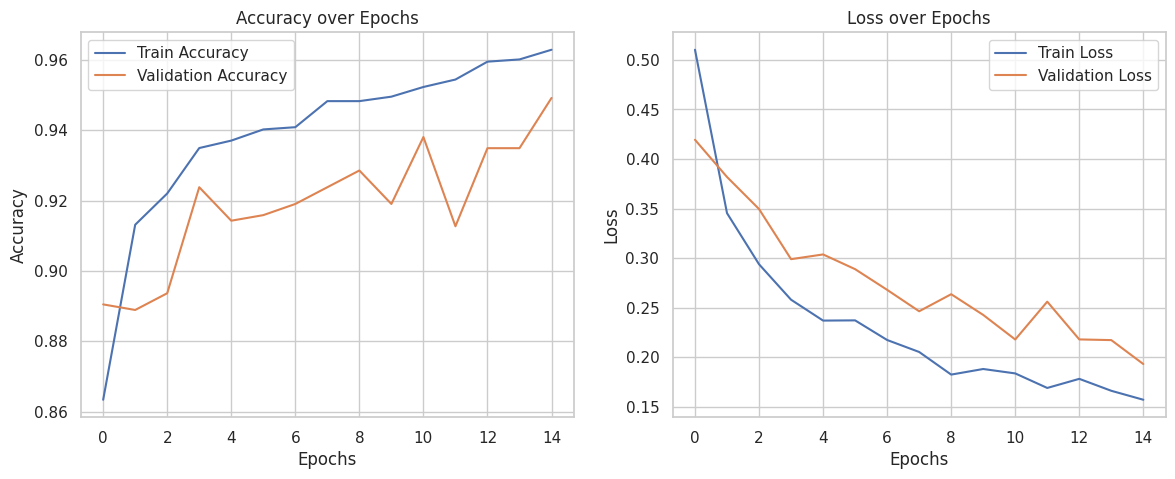

In [18]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

## 8. Genel Model Değerlendirmesi

Bu bölümde, eğitilen CNN modelimizin performansı karışıklık matrisi ve sınıflandırma raporu üzerinden detaylı olarak incelenmiştir.

---

### 8.1. Karışıklık Matrisi

|                 | Predicted Normal | Predicted Tuberculosis |
|-----------------|----------------|-----------------------|
| **Actual Normal**       | 518            | 7                     |
| **Actual Tuberculosis** | 36             | 69                    |


- **Normal sınıfı:** 525 örnekten 518 doğru sınıflandırılmıştır. Model, sağlıklı bireyleri tespit etmede oldukça başarılıdır. Yanlış pozitif sayısı (False Positive) sadece 7’dur. Bu yüksek doğruluk, modelin sağlıklı bireyleri tespit etmede oldukça başarılı olduğunu göstermektedir. False Positive sayısının düşük olması, modelin Normal örnekleri yanlışlıkla hastalık olarak işaretleme eğiliminin az olduğunu ifade eder.  
- **Tüberküloz sınıfı:** 105 örnekten 69 doğru sınıflandırılmış, 36 örnek yanlışlıkla Normal olarak tahmin edilmiştir. False Negative sayısının yüksek olması, kritik hastalık vakalarının atlanabileceğini göstermektedir. Tüberküloz verisinin daha çok olması durumunda başarısı arttırılır.

---

### 8.2. Classification Report

Tüberküloz sınıfı: Modelin precision ve recall değerleri sırasıyla 0.94 ve 0.99 olarak hesaplanmıştır. Yüksek recall değeri, modelin tüberküloz vakalarının büyük çoğunluğunu doğru şekilde tespit ettiğini göstermektedir. F1-score 0.96 ile sınıfın genel performansının oldukça iyi olduğunu doğrulamaktadır.

Normal sınıfı: Precision 0.91 olarak iyi seviyede olmasına rağmen recall 0.66’dır. Bu durum, modelin bazı sağlıklı örnekleri yanlışlıkla tüberküloz olarak sınıflandırdığını (False Negative) göstermektedir. Bu sonuç, özellikle klinik uygulamalarda gereksiz alarm riskini işaret etmektedir.


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step


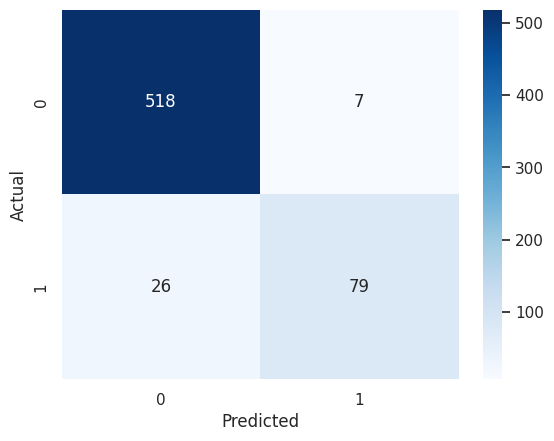

              precision    recall  f1-score   support

Tuberculosis       0.95      0.99      0.97       525
      Normal       0.92      0.75      0.83       105

    accuracy                           0.95       630
   macro avg       0.94      0.87      0.90       630
weighted avg       0.95      0.95      0.95       630



In [19]:
# Test tahminleri
y_pred = model.predict(test_generator)
y_pred_classes = np.where(y_pred>0.5, 1, 0)

# Gerçek etiketler
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=classes))


## 9. Grad-CAM ile Görselleştirme

Bu kod, eğitilen CNN modelimizin **hangi bölgelerden etkilenerek sınıflandırma yaptığı**nı görselleştirmek için Grad-CAM (Gradient-weighted Class Activation Mapping) tekniğini uygular.


- **Amaç:** Modelin sınıflandırma kararlarını görselleştirmek. Özellikle tıbbi görüntülerde, modelin **hastalıklı bölgeleri doğru şekilde fark edip etmediğini** analiz etmek için kullanılır.  
- **Teknik:** Grad-CAM, son konvolüsyon katmanı çıkışlarını ve hedef sınıf için gradyanları kullanarak, sınıfa en çok katkıda bulunan bölgeleri vurgulayan bir heatmap üretir.  
- **Neden son konvolüsyon katmanı:** Bu katman, hem yüksek düzeyde özellik çıkarır hem de konumsal bilgiyi korur; böylece heatmap, görüntü üzerinde anlamlı bölgeleri gösterebilir.

---

### 9.2 Kodun İşleyişi

1. **Ara model oluşturma:**  
   Modelin son konvolüsyon katmanı ve çıktısı alınır (`grad_model`).  

2. **Gradient hesaplama:**  
   - Tahmin edilen sınıf (veya varsayılan olarak en yüksek olasılıklı sınıf) seçilir.  
   - `GradientTape` ile bu sınıfın çıkışı ve konvolüsyon katmanı çıkışı arasındaki gradyanlar hesaplanır.  

3. **Heatmap oluşturma:**  
   - Gradyanlar tüm uzaysal boyutlar üzerinden ortalanır (pooled_grads).  
   - Bu değerler, konvolüsyon çıkışlarıyla çarpılarak sınıfa en çok katkıda bulunan bölgeler tespit edilir.  
   - Sonuç normalize edilip pozitif değerler alınır ve heatmap üretilir.

4. **Görselleştirme:**  
   - Heatmap, orijinal görüntü ile birleşir (`addWeighted`) ve modelin hangi alanlara dikkat ettiğini görselleştirir.  
   - Birden fazla örnek için yan yana orijinal ve Grad-CAM görüntüleri gösterilir.


In [20]:
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array])  # <- listeye aldık
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap  

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=['Tensor(shape=(1, 224, 224, 1))']
  warnings.warn(msg)


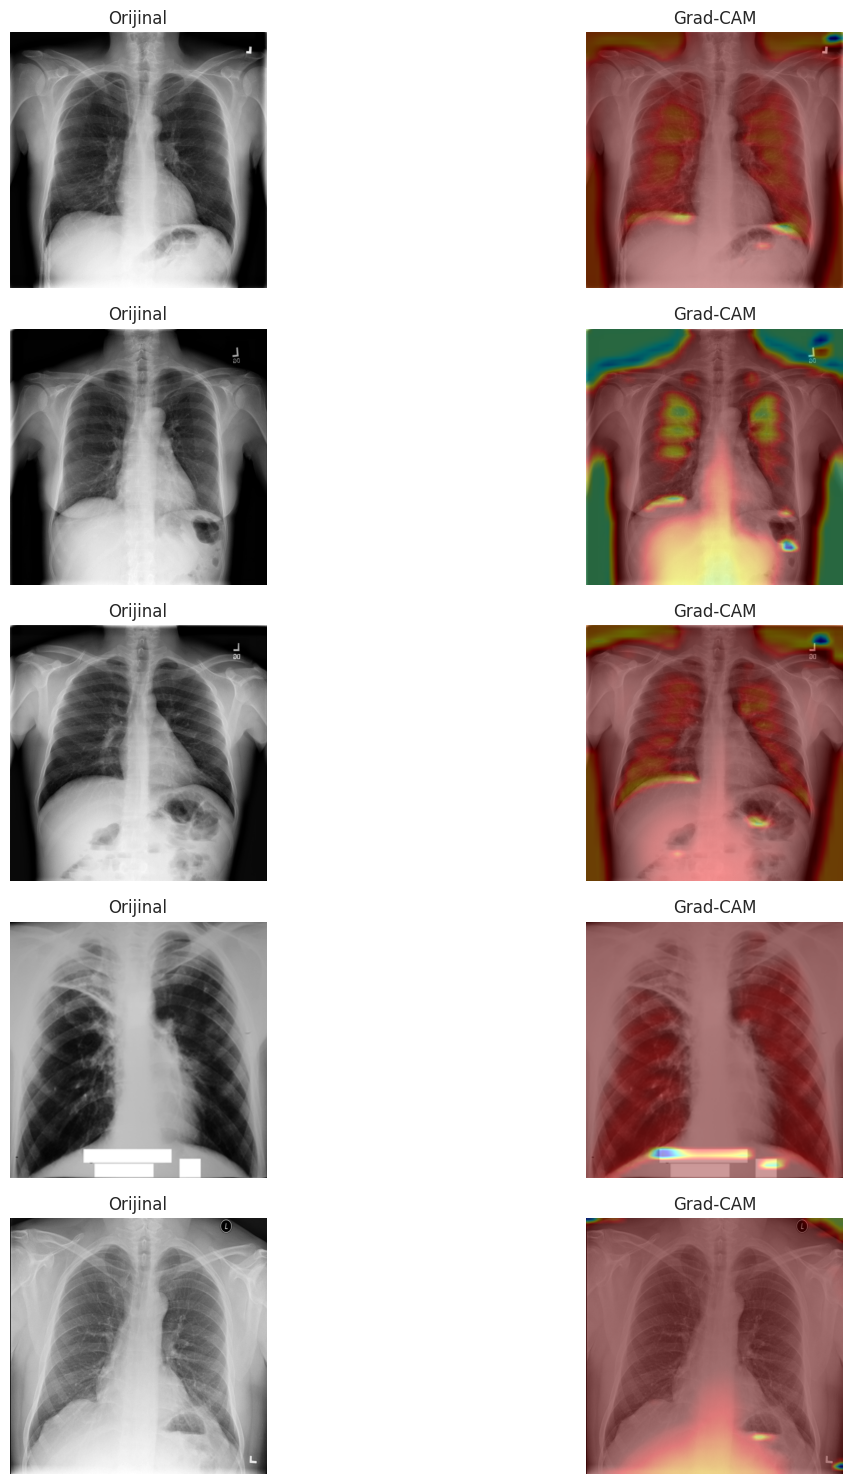

In [21]:
num_examples = 5
example_paths = df_test['filename'].sample(num_examples, random_state=42).tolist()

plt.figure(figsize=(15, num_examples*3))

for i, img_path in enumerate(example_paths):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224,224))
    input_img = img_resized.reshape((1,224,224,1)) / 255.0

    heatmap = make_gradcam_heatmap(model, input_img, 'last_conv')
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    superimposed_img = cv2.addWeighted(superimposed_img, 0.6, heatmap_colored, 0.4, 0)

    plt.subplot(num_examples, 2, i*2+1)
    plt.imshow(img, cmap='gray')
    plt.title('Orijinal')
    plt.axis('off')

    plt.subplot(num_examples, 2, i*2+2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()


## 10. Hiperparametre Optimizasyonu

Bu bölümde, CNN modelimizin hiperparametrelerini optimize etmek için Keras Tuner’ın Hyperband algoritması kullanılmıştır. Hyperband, kaynakları daha verimli kullanarak iyi performans gösteren modelleri hızlıca bulmayı amaçlar.

In [22]:
from kerastuner.tuners import Hyperband

tuner = Hyperband(
    MyHyperModel(),
    objective='val_accuracy',
    max_epochs=10,          
    factor=3,              
    directory='tuner_results',
    project_name='tb_cnn_hb'
)

tuner.search(train_generator, validation_data=val_generator)
best_model = tuner.get_best_models(num_models=1)[0]


/tmp/ipykernel_19/4096110522.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


NameError: name 'MyHyperModel' is not defined